# Storm Events Patrerns and Trends

In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import sys
import os
sys.path.append(os.path.abspath("../src"))

In [4]:
from data_cleaner import load_yearly_and_clean
from column_groups import column_groups

In [5]:
all_years = []
for year in range(1996, 2026):
    df_year = load_yearly_and_clean(year)
    all_years.append(df_year)

df = pd.concat(all_years, ignore_index=True)

/Users/susmitasingh/Documents/GitHub/Parametric_Weather_Risk_Modeling/src/data_cleaner.py:198: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_d = pd.read_csv(fileDName)
/Users/susmitasingh/Documents/GitHub/Parametric_Weather_Risk_Modeling/src/data_cleaner.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['BEGIN_DATE_TIME'] = pd.to_datetime(df['BEGIN_DATE_TIME'], errors='coerce')
/Users/susmitasingh/Documents/GitHub/Parametric_Weather_Risk_Modeling/src/data_cleaner.py:66: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['END_DATE_TIME']   = pd.to_datetime(df['END_DATE_TIME'], errors='coerce')
/Users/susmitasingh/Documents/GitHub/Parametric_Weath

In [6]:
df.to_parquet("../data/cleaned/all_years_cleaned.parquet", index=False)

In [7]:
df.to_csv("../data/cleaned/all_years_cleaned.csv", index=False)

In [8]:
df_all = pd.read_parquet("../data/cleaned/all_years_cleaned.parquet")

In [9]:
df_all.head()

,BEGIN_DAY,END_DAY,EPISODE_ID,EVENT_ID,STATE,YEAR,EVENT_TYPE,CZ_TYPE,CZ_NAME,INJURIES_DIRECT,...,BEGIN_LAT,BEGIN_LON,FAT_DAY,FATALITY_ID,BEGIN_MONTH,END_MONTH,BEGIN_MONTH_NAME,DURATION_DAYS,LOCATION_LABEL,TOTAL_DAMAGE
0,29,30,2052149,5570068,ILLINOIS,1996,High Wind,Zone,HANCOCK,0,...,NaN,NaN,<NA>,<NA>,10,10,Oct,2,"HANCOCK, ILLINOIS",NaN
1,21,21,2052748,5570362,OKLAHOMA,1996,Flash Flood,County,BRYAN,0,...,NaN,NaN,<NA>,<NA>,10,10,Oct,1,"DURANT, BRYAN, OKLAHOMA",NaN
2,20,20,2052749,5570363,OKLAHOMA,1996,Hail,County,STEPHENS,0,...,34.42,-98.03,<NA>,<NA>,10,10,Oct,1,"EMPIRE CITY, STEPHENS, OKLAHOMA",NaN
3,23,24,2404440,5537534,CALIFORNIA,1996,Winter Storm,Zone,COASTAL MONTEREY COUNTY,0,...,NaN,NaN,<NA>,<NA>,1,1,Jan,2,"COASTAL MONTEREY COUNTY, CALIFORNIA",NaN
4,17,18,2404601,5538413,MINNESOTA,1996,Blizzard,Zone,YELLOW MEDICINE,0,...,NaN,NaN,<NA>,<NA>,1,1,Jan,2,"YELLOW MEDICINE, MINNESOTA",NaN


In [10]:
event_types = list(df_all['EVENT_TYPE'].unique())
len(event_types)

57

There are a total of 57 different event types. To make the analysis comprehensible we determine the most important event types based on frequency and damage caused. 

## Individual Event Types

In [13]:
event_summary = df.groupby("EVENT_TYPE").agg(
    EVENTS=("EVENT_ID", "count"),
    TOTAL_PROPERTY_DAMAGE=("DAMAGE_PROPERTY", "sum"),
    TOTAL_CROP_DAMAGE=("DAMAGE_CROPS", "sum"),
    TOTAL_INJURIES=("INJURIES_DIRECT", "sum"),
    TOTAL_DEATHS=("DEATHS_DIRECT", "sum"),
    TOTAL_DAMAGE=("TOTAL_DAMAGE", "sum")
).reset_index()


## Summmary Overview

In [15]:
event_summary.sort_values("TOTAL_DAMAGE", ascending=False).head(10)

,EVENT_TYPE,EVENTS,TOTAL_PROPERTY_DAMAGE,TOTAL_CROP_DAMAGE,TOTAL_INJURIES,TOTAL_DEATHS,TOTAL_DAMAGE
13,Flash Flood,313370,4.137698e+12,1.018331e+10,24528,30045,4147881321470.0
25,Hurricane (Typhoon),3345,3.809890e+12,1.848592e+10,4107,444305,3828375563110.0
54,Wildfire,9508,2.064793e+12,8.555521e+08,8850,20177,2065648520020.0
47,Tornado,69626,1.359655e+12,1.041037e+09,656005,81195,1360695996880.0
14,Flood,223912,3.390040e+11,2.845390e+10,3299,4363,367457943130.0
49,Tropical Storm,7293,1.321865e+11,3.072679e+09,404,895,135259187250.0
44,Storm Surge/Tide,1676,1.071189e+11,9.550000e+05,45,210,107119870340.0
5,Debris Flow,7188,6.356235e+10,2.015980e+07,16469,9917,63582507270.0
18,Hail,345293,3.993734e+10,4.845384e+09,1092,9,44782720690.0
8,Drought,79240,2.160425e+09,2.911631e+10,354,0,31276735480.0


## Damage Over Time

/var/folders/7k/nlypnkss53lgj28ffmqzrtlh0000gn/T/ipykernel_85829/1265335816.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  damage_pivot = damage_trend_top.pivot(index="YEAR", columns="EVENT_TYPE", values="TOTAL_DAMAGE").fillna(0)


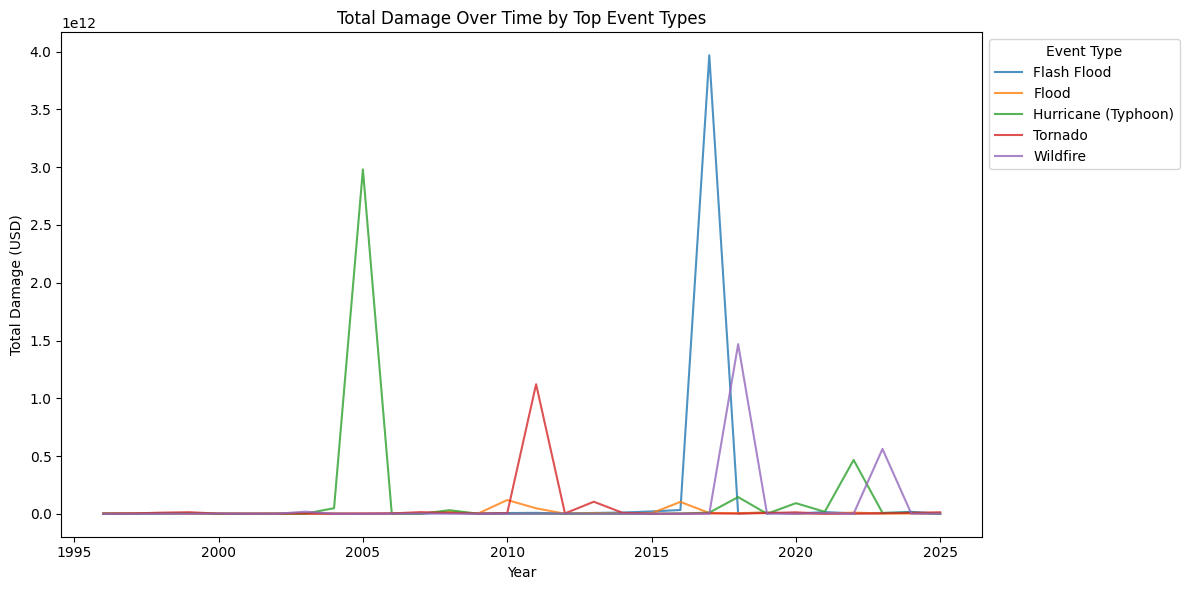

In [33]:
# Aggregate damages by year and event type
damage_trend = df.groupby(["YEAR", "EVENT_TYPE"])["TOTAL_DAMAGE"].sum().reset_index()

# Pick top N event types by overall damages
top_event_types = (
    damage_trend.groupby("EVENT_TYPE")["TOTAL_DAMAGE"].sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

# Keep only top event types
damage_trend_top = damage_trend[damage_trend["EVENT_TYPE"].isin(top_event_types)]

# Pivot to wide format for stacked area
damage_pivot = damage_trend_top.pivot(index="YEAR", columns="EVENT_TYPE", values="TOTAL_DAMAGE").fillna(0)

# Plot stacked area
plt.figure(figsize=(12, 6))
damage_pivot.plot(ax=plt.gca(), alpha=0.8)

plt.title("Total Damage Over Time by Top Event Types")
plt.xlabel("Year")
plt.ylabel("Total Damage (USD)")
plt.legend(title="Event Type", loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

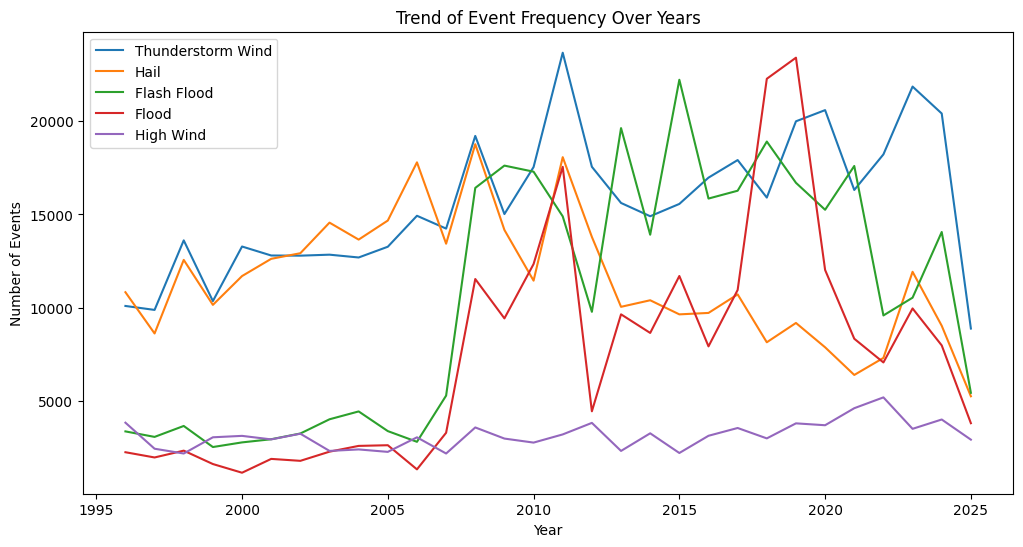

In [36]:
# Aggregate number of events per year per event type
freq_trend = df.groupby(["YEAR", "EVENT_TYPE"]).size().reset_index(name="event_count")

# Optionally, focus on top N event types by total frequency
top_event_types = freq_trend.groupby("EVENT_TYPE")["event_count"].sum().nlargest(5).index
freq_trend_top = freq_trend[freq_trend["EVENT_TYPE"].isin(top_event_types)]

# Plot
plt.figure(figsize=(12,6))
for event in top_event_types:
    data = freq_trend_top[freq_trend_top["EVENT_TYPE"] == event]
    plt.plot(data["YEAR"], data["event_count"], label=event)

plt.title("Trend of Event Frequency Over Years")
plt.xlabel("Year")
plt.ylabel("Number of Events")
plt.legend()
plt.show()


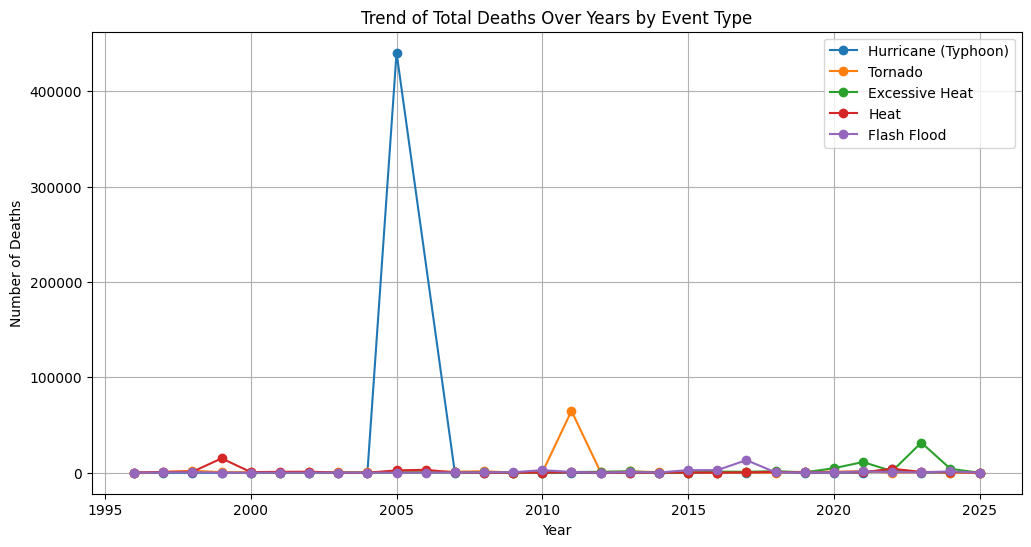

In [41]:
# Create a total deaths column
df["TOTAL_DEATHS"] = df["DEATHS_DIRECT"] + df["DEATHS_INDIRECT"]

# Aggregate total deaths per year per event type
death_trend = df.groupby(["YEAR", "EVENT_TYPE"])["TOTAL_DEATHS"].sum().reset_index()

# Focus on top N event types by total deaths
top_event_types = death_trend.groupby("EVENT_TYPE")["TOTAL_DEATHS"].sum().nlargest(5).index
death_trend_top = death_trend[death_trend["EVENT_TYPE"].isin(top_event_types)]

# Plot
plt.figure(figsize=(12,6))
for event in top_event_types:
    data = death_trend_top[death_trend_top["EVENT_TYPE"] == event]
    plt.plot(data["YEAR"], data["TOTAL_DEATHS"], marker='o', label=event)

plt.title("Trend of Total Deaths Over Years by Event Type")
plt.xlabel("Year")
plt.ylabel("Number of Deaths")
plt.legend()
plt.grid(True)
plt.show()
